In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# Got the values from ImageTransformations.ipynb
mean = [0.49159187, 0.48234594, 0.44671956] 
std = [0.23834434, 0.23486559, 0.25264624]

In [3]:
train_transform = T.Compose([
                             T.Resize(32),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean, std)
])

In [5]:
test_transform = T.Compose([
                             T.Resize(32),
                             T.ToTensor(),
                             T.Normalize(mean, std)
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='data/cifar10/train',
                                        train=True,
                                        download=True,
                                        transform=train_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/train/cifar-10-python.tar.gz to data/cifar10/train


In [6]:
testset = torchvision.datasets.CIFAR10(root='data/cifar10/test',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar10/test/cifar-10-python.tar.gz to data/cifar10/test


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=2)

In [8]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
img, label = iter(trainloader).next()
img.shape

torch.Size([16, 3, 32, 32])

In [10]:
label

tensor([8, 0, 0, 1, 8, 2, 1, 8, 8, 4, 2, 9, 6, 4, 6, 3])

In [11]:
CHANNELS = 3
HIDDEN = [16, 32]
OUTPUT = [400, 10]
KERNEL = 5

In [12]:
class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(HIDDEN[1] * 5 * 5, OUTPUT[0]), # (5,5) is the final image size of layer 2
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(OUTPUT[0], OUTPUT[1])
    )
  
  def forward(self, x):

    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer3(out)
    return F.log_softmax(out, dim=-1)

In [13]:
model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [14]:
LEARNING_RATE = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
total_step = len(trainloader)
EPOCHS = 25
losses = []

for epoch in range(1, EPOCHS + 1):

  for i, (images, labels) in enumerate(trainloader):

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch}/{EPOCHS}], Batch [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

print('Finished training...')

Streaming output truncated to the last 5000 lines.
Epoch [24/25], Batch [1252/3125], Loss: 0.4308
Epoch [24/25], Batch [1253/3125], Loss: 0.4751
Epoch [24/25], Batch [1254/3125], Loss: 0.5788
Epoch [24/25], Batch [1255/3125], Loss: 0.8119
Epoch [24/25], Batch [1256/3125], Loss: 0.8896
Epoch [24/25], Batch [1257/3125], Loss: 1.0423
Epoch [24/25], Batch [1258/3125], Loss: 1.3036
Epoch [24/25], Batch [1259/3125], Loss: 0.7860
Epoch [24/25], Batch [1260/3125], Loss: 0.5791
Epoch [24/25], Batch [1261/3125], Loss: 0.8687
Epoch [24/25], Batch [1262/3125], Loss: 0.5298
Epoch [24/25], Batch [1263/3125], Loss: 0.7983
Epoch [24/25], Batch [1264/3125], Loss: 0.8988
Epoch [24/25], Batch [1265/3125], Loss: 0.4083
Epoch [24/25], Batch [1266/3125], Loss: 0.9783
Epoch [24/25], Batch [1267/3125], Loss: 0.3462
Epoch [24/25], Batch [1268/3125], Loss: 0.8947
Epoch [24/25], Batch [1269/3125], Loss: 0.6517
Epoch [24/25], Batch [1270/3125], Loss: 0.4240
Epoch [24/25], Batch [1271/3125], Loss: 0.9972
Epoch [24

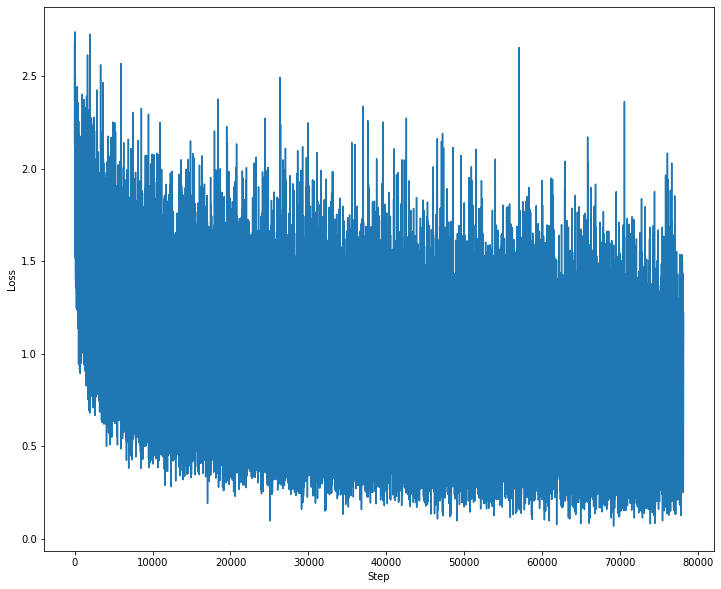

In [16]:
x = range(len(losses))
plt.figure(figsize=(12, 10))
plt.plot(x, losses)
plt.xlabel('Step')
plt.ylabel('Loss');

In [19]:
model.eval()

with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  
  print(f'Test Accuracy: {100 * correct / total:.4f}')

Test Accuracy: 76.0200


Epoch [1/10], Batch [1/3125], Loss: 2.1716
Epoch [1/10], Batch [1001/3125], Loss: 1.9405
Epoch [1/10], Batch [2001/3125], Loss: 1.5654
Epoch [1/10], Batch [3001/3125], Loss: 1.3053
Epoch [2/10], Batch [1/3125], Loss: 2.1355
Epoch [2/10], Batch [1001/3125], Loss: 1.1771
Epoch [2/10], Batch [2001/3125], Loss: 1.1458
Epoch [2/10], Batch [3001/3125], Loss: 1.6756
Epoch [3/10], Batch [1/3125], Loss: 1.5041
Epoch [3/10], Batch [1001/3125], Loss: 1.4058
Epoch [3/10], Batch [2001/3125], Loss: 1.4873
Epoch [3/10], Batch [3001/3125], Loss: 0.7921
Epoch [4/10], Batch [1/3125], Loss: 1.0740
Epoch [4/10], Batch [1001/3125], Loss: 1.2504
Epoch [4/10], Batch [2001/3125], Loss: 1.2676
Epoch [4/10], Batch [3001/3125], Loss: 1.1154
Epoch [5/10], Batch [1/3125], Loss: 0.8500
Epoch [5/10], Batch [1001/3125], Loss: 1.0212
Epoch [5/10], Batch [2001/3125], Loss: 1.2784
Epoch [5/10], Batch [3001/3125], Loss: 1.3776
Epoch [6/10], Batch [1/3125], Loss: 0.8332
Epoch [6/10], Batch [1001/3125], Loss: 1.2968
Epoch 

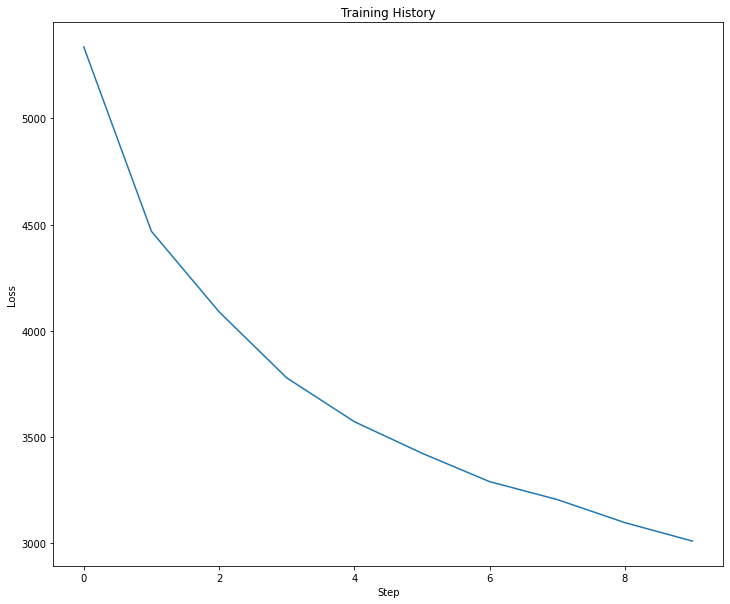

Test Accuracy: 68.5900


In [21]:
# Sigmoid Activation

CHANNELS = 3
HIDDEN = [16, 32]
OUTPUT = [400, 10]
KERNEL = 5

class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(HIDDEN[1] * 5 * 5, OUTPUT[0]), # (5,5) is the final image size of layer 2
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(OUTPUT[0], OUTPUT[1])
    )
  
  def forward(self, x):

    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer3(out)
    return F.log_softmax(out, dim=-1)

model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

LEARNING_RATE = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_step = len(trainloader)
EPOCHS = 10
losses = []

for epoch in range(1, EPOCHS + 1):

  losses_epoch = []

  for i, (images, labels) in enumerate(trainloader):

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
      print(f'Epoch [{epoch}/{EPOCHS}], Batch [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    losses_epoch.append(loss.item())
  
  sum_loss = sum(losses_epoch)
  losses.append(sum_loss)

print('Finished training...')

x = range(len(losses))
plt.figure(figsize=(12, 10))
plt.plot(x, losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training History')
plt.show();

model.eval()

with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  
  print(f'Test Accuracy: {100 * correct / total:.4f}')

Epoch [1/10], Batch [1/3125], Loss: 2.3036
Epoch [1/10], Batch [1501/3125], Loss: 1.7947
Epoch [1/10], Batch [3001/3125], Loss: 1.6436
Epoch [2/10], Batch [1/3125], Loss: 1.1177
Epoch [2/10], Batch [1501/3125], Loss: 1.1972
Epoch [2/10], Batch [3001/3125], Loss: 1.6920
Epoch [3/10], Batch [1/3125], Loss: 0.7782
Epoch [3/10], Batch [1501/3125], Loss: 1.0214
Epoch [3/10], Batch [3001/3125], Loss: 0.6883
Epoch [4/10], Batch [1/3125], Loss: 0.8478
Epoch [4/10], Batch [1501/3125], Loss: 1.0554
Epoch [4/10], Batch [3001/3125], Loss: 1.0746
Epoch [5/10], Batch [1/3125], Loss: 1.4446
Epoch [5/10], Batch [1501/3125], Loss: 0.9452
Epoch [5/10], Batch [3001/3125], Loss: 0.7345
Epoch [6/10], Batch [1/3125], Loss: 1.1311
Epoch [6/10], Batch [1501/3125], Loss: 1.4823
Epoch [6/10], Batch [3001/3125], Loss: 0.8531
Epoch [7/10], Batch [1/3125], Loss: 1.2503
Epoch [7/10], Batch [1501/3125], Loss: 0.9807
Epoch [7/10], Batch [3001/3125], Loss: 0.9474
Epoch [8/10], Batch [1/3125], Loss: 0.7056
Epoch [8/10]

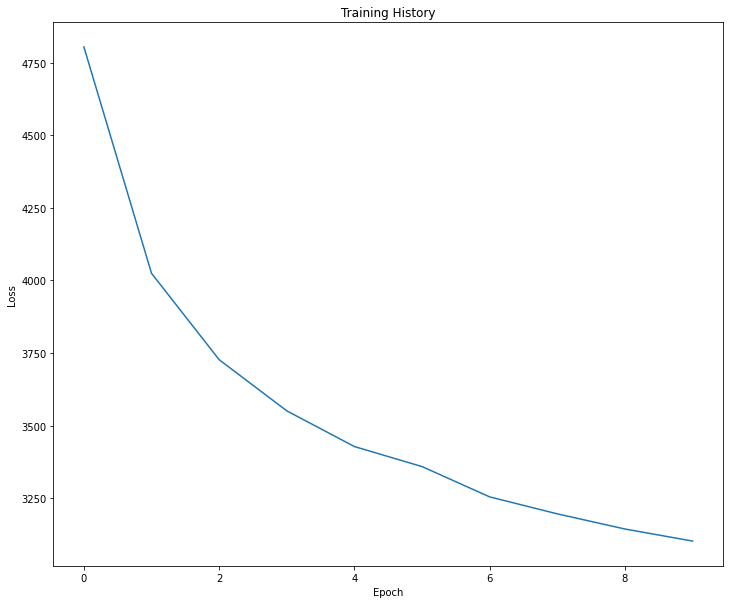

Test Accuracy: 67.460


In [22]:
# Tanh Activation

CHANNELS = 3
HIDDEN = [16, 32]
OUTPUT = [400, 10]
KERNEL = 5

class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(HIDDEN[1] * 5 * 5, OUTPUT[0]), # (5,5) is the final image size of layer 2
        nn.Tanh(),
        nn.Dropout(0.5),
        nn.Linear(OUTPUT[0], OUTPUT[1])
    )
  
  def forward(self, x):

    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer3(out)
    return F.log_softmax(out, dim=-1)

model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

LEARNING_RATE = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_step = len(trainloader)
EPOCHS = 10
losses = []

for epoch in range(1, EPOCHS + 1):

  losses_epoch = []

  for i, (images, labels) in enumerate(trainloader):

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1500 == 0:
      print(f'Epoch [{epoch}/{EPOCHS}], Batch [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    losses_epoch.append(loss.item())
  
  sum_loss = sum(losses_epoch)
  losses.append(sum_loss)

print('Finished training...')

x = range(len(losses))
plt.figure(figsize=(12, 10))
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.show();

model.eval()

with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  
  print(f'Test Accuracy: {100 * correct / total:.3f}')

Epoch [1/10], Batch [1/3125], Loss: 2.3522
Epoch [1/10], Batch [1501/3125], Loss: 0.9800
Epoch [1/10], Batch [3001/3125], Loss: 1.1070
Epoch [2/10], Batch [1/3125], Loss: 1.3153
Epoch [2/10], Batch [1501/3125], Loss: 0.9367
Epoch [2/10], Batch [3001/3125], Loss: 1.3679
Epoch [3/10], Batch [1/3125], Loss: 0.8906
Epoch [3/10], Batch [1501/3125], Loss: 0.6095
Epoch [3/10], Batch [3001/3125], Loss: 1.1894
Epoch [4/10], Batch [1/3125], Loss: 0.9883
Epoch [4/10], Batch [1501/3125], Loss: 0.7862
Epoch [4/10], Batch [3001/3125], Loss: 0.7624
Epoch [5/10], Batch [1/3125], Loss: 1.0015
Epoch [5/10], Batch [1501/3125], Loss: 0.7329
Epoch [5/10], Batch [3001/3125], Loss: 0.8738
Epoch [6/10], Batch [1/3125], Loss: 1.0721
Epoch [6/10], Batch [1501/3125], Loss: 1.2620
Epoch [6/10], Batch [3001/3125], Loss: 1.3038
Epoch [7/10], Batch [1/3125], Loss: 0.4994
Epoch [7/10], Batch [1501/3125], Loss: 0.7906
Epoch [7/10], Batch [3001/3125], Loss: 0.6368
Epoch [8/10], Batch [1/3125], Loss: 0.9165
Epoch [8/10]

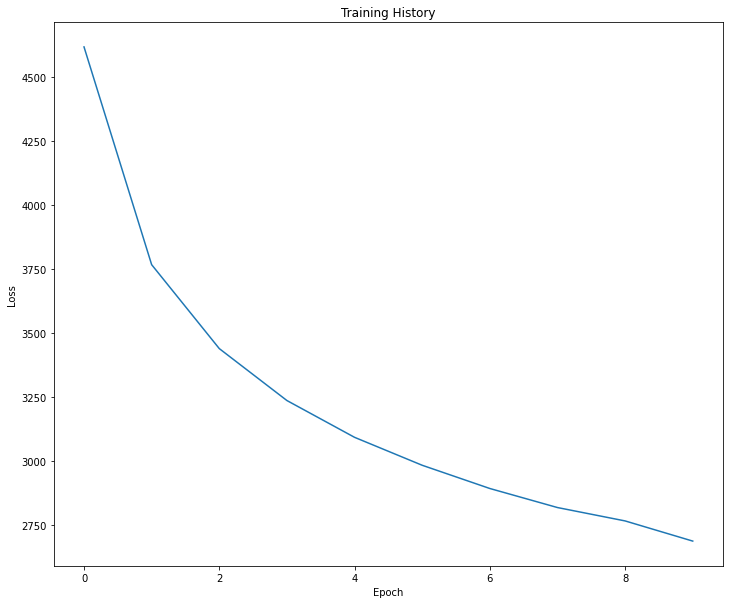

Test Accuracy: 72.320


In [23]:
# ELU Activation

CHANNELS = 3
HIDDEN = [16, 32]
OUTPUT = [400, 10]
KERNEL = 5

class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(HIDDEN[1] * 5 * 5, OUTPUT[0]), # (5,5) is the final image size of layer 2
        nn.ELU(),
        nn.Dropout(0.5),
        nn.Linear(OUTPUT[0], OUTPUT[1])
    )
  
  def forward(self, x):

    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer3(out)
    return F.log_softmax(out, dim=-1)

model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

LEARNING_RATE = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_step = len(trainloader)
EPOCHS = 10
losses = []

for epoch in range(1, EPOCHS + 1):

  losses_epoch = []

  for i, (images, labels) in enumerate(trainloader):

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1500 == 0:
      print(f'Epoch [{epoch}/{EPOCHS}], Batch [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    losses_epoch.append(loss.item())
  
  sum_loss = sum(losses_epoch)
  losses.append(sum_loss)

print('Finished training...')

x = range(len(losses))
plt.figure(figsize=(12, 10))
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.show();

model.eval()

with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  
  print(f'Test Accuracy: {100 * correct / total:.3f}')

Epoch [1/10], Batch [1/3125], Loss: 2.3121
Epoch [1/10], Batch [1501/3125], Loss: 1.3127
Epoch [1/10], Batch [3001/3125], Loss: 1.0271
Epoch [2/10], Batch [1/3125], Loss: 0.8425
Epoch [2/10], Batch [1501/3125], Loss: 1.0803
Epoch [2/10], Batch [3001/3125], Loss: 1.0875
Epoch [3/10], Batch [1/3125], Loss: 0.8764
Epoch [3/10], Batch [1501/3125], Loss: 0.7234
Epoch [3/10], Batch [3001/3125], Loss: 0.9337
Epoch [4/10], Batch [1/3125], Loss: 1.1527
Epoch [4/10], Batch [1501/3125], Loss: 1.2219
Epoch [4/10], Batch [3001/3125], Loss: 0.8189
Epoch [5/10], Batch [1/3125], Loss: 1.7859
Epoch [5/10], Batch [1501/3125], Loss: 0.8652
Epoch [5/10], Batch [3001/3125], Loss: 0.9064
Epoch [6/10], Batch [1/3125], Loss: 0.8545
Epoch [6/10], Batch [1501/3125], Loss: 0.8497
Epoch [6/10], Batch [3001/3125], Loss: 0.8617
Epoch [7/10], Batch [1/3125], Loss: 1.2564
Epoch [7/10], Batch [1501/3125], Loss: 1.6185
Epoch [7/10], Batch [3001/3125], Loss: 1.3102
Epoch [8/10], Batch [1/3125], Loss: 0.7194
Epoch [8/10]

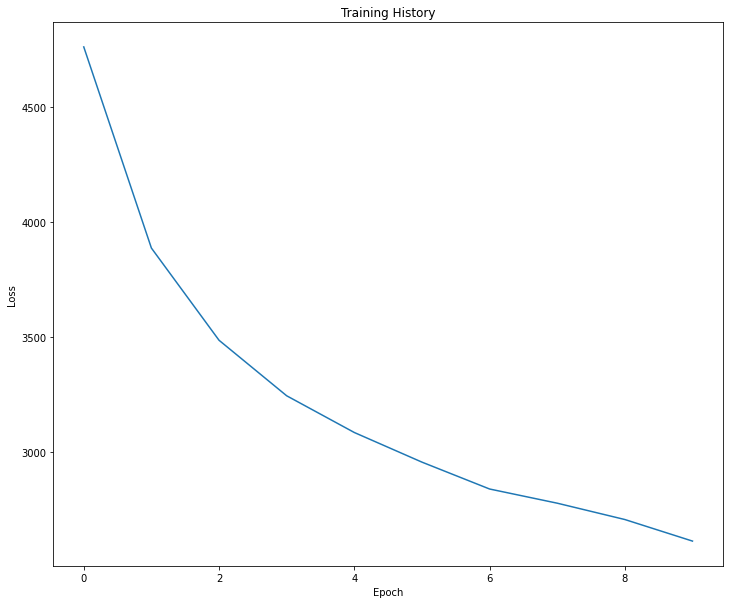

Test Accuracy: 73.660


In [25]:
# ReLU with Mean Pooling

CHANNELS = 3
HIDDEN = [16, 32]
OUTPUT = [400, 10]
KERNEL = 5

class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(CHANNELS, HIDDEN[0], KERNEL),
        nn.BatchNorm2d(HIDDEN[0]),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(HIDDEN[0], HIDDEN[1], KERNEL),
        nn.BatchNorm2d(HIDDEN[1]),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(HIDDEN[1] * 5 * 5, OUTPUT[0]), # (5,5) is the final image size of layer 2
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(OUTPUT[0], OUTPUT[1])
    )
  
  def forward(self, x):

    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.layer3(out)
    return F.log_softmax(out, dim=-1)

model = ConvNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

LEARNING_RATE = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_step = len(trainloader)
EPOCHS = 10
losses = []

for epoch in range(1, EPOCHS + 1):

  losses_epoch = []

  for i, (images, labels) in enumerate(trainloader):

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1500 == 0:
      print(f'Epoch [{epoch}/{EPOCHS}], Batch [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
    losses_epoch.append(loss.item())
  
  sum_loss = sum(losses_epoch)
  losses.append(sum_loss)

print('Finished training...')

x = range(len(losses))
plt.figure(figsize=(12, 10))
plt.plot(x, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.show();

model.eval()

with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  
  print(f'Test Accuracy: {100 * correct / total:.3f}')